<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span><ul class="toc-item"><li><span><a href="#Software-and-conventions" data-toc-modified-id="Software-and-conventions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Software and conventions</a></span></li></ul></li><li><span><a href="#Recap-of-lessons-1-and-2,-,-compiling-and-running-WRF-Hydro" data-toc-modified-id="Recap-of-lessons-1-and-2,-,-compiling-and-running-WRF-Hydro-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Recap of lessons 1 and 2, , compiling and running WRF-Hydro</a></span><ul class="toc-item"><li><span><a href="#Compiling-WRF-Hydro" data-toc-modified-id="Compiling-WRF-Hydro-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Compiling WRF-Hydro</a></span></li><li><span><a href="#Creating-the-simulation-directory-and-running-a-baseline-WRF-Hydro-simulation" data-toc-modified-id="Creating-the-simulation-directory-and-running-a-baseline-WRF-Hydro-simulation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Creating the simulation directory and running a baseline WRF-Hydro simulation</a></span></li></ul></li><li><span><a href="#Experimenting-with-run-time-options" data-toc-modified-id="Experimenting-with-run-time-options-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Experimenting with run-time options</a></span><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Setup</a></span></li></ul></li><li><span><a href="#Experiment-1---Warm-vs-Cold-start" data-toc-modified-id="Experiment-1---Warm-vs-Cold-start-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Experiment 1 - Warm vs Cold start</a></span><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Objective" data-toc-modified-id="Objective-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Objective</a></span></li><li><span><a href="#Create-experiment-simulation-directory" data-toc-modified-id="Create-experiment-simulation-directory-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Create experiment simulation directory</a></span></li><li><span><a href="#Edit-the-namelists-and-run-the-simulation" data-toc-modified-id="Edit-the-namelists-and-run-the-simulation-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Edit the namelists and run the simulation</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Hydrographs" data-toc-modified-id="Hydrographs-4.5.1"><span class="toc-item-num">4.5.1&nbsp;&nbsp;</span>Hydrographs</a></span></li><li><span><a href="#Soil-moisture-at-start-of-simulation" data-toc-modified-id="Soil-moisture-at-start-of-simulation-4.5.2"><span class="toc-item-num">4.5.2&nbsp;&nbsp;</span>Soil moisture at start of simulation</a></span></li></ul></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Discussion</a></span></li></ul></li><li><span><a href="#Experiment-2---Supplemental-Precipitation-Data" data-toc-modified-id="Experiment-2---Supplemental-Precipitation-Data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Experiment 2 - Supplemental Precipitation Data</a></span><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Objective" data-toc-modified-id="Objective-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Objective</a></span></li><li><span><a href="#Create-experiment-simulation-directory" data-toc-modified-id="Create-experiment-simulation-directory-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Create experiment simulation directory</a></span></li><li><span><a href="#Edit-the-namelist-and-FORCING-data-and-run-the-simulation" data-toc-modified-id="Edit-the-namelist-and-FORCING-data-and-run-the-simulation-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Edit the namelist and FORCING data and run the simulation</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Hydrographs" data-toc-modified-id="Hydrographs-5.5.1"><span class="toc-item-num">5.5.1&nbsp;&nbsp;</span>Hydrographs</a></span></li><li><span><a href="#Precipitation-data" data-toc-modified-id="Precipitation-data-5.5.2"><span class="toc-item-num">5.5.2&nbsp;&nbsp;</span>Precipitation data</a></span></li></ul></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Discussion</a></span></li></ul></li><li><span><a href="#Experiment-3---Groundwater-model-options" data-toc-modified-id="Experiment-3---Groundwater-model-options-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Experiment 3 - Groundwater model options</a></span><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Objective" data-toc-modified-id="Objective-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Objective</a></span></li><li><span><a href="#Create-experiment-simulation-directory" data-toc-modified-id="Create-experiment-simulation-directory-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Create experiment simulation directory</a></span></li><li><span><a href="#Edit-the-namelists-and-run-the-simulation-for-the-pass-through-model" data-toc-modified-id="Edit-the-namelists-and-run-the-simulation-for-the-pass-through-model-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Edit the namelists and run the simulation for the pass through model</a></span></li><li><span><a href="#Edit-the-namelists-and-run-the-simulation-for-no-groundwater-routing" data-toc-modified-id="Edit-the-namelists-and-run-the-simulation-for-no-groundwater-routing-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Edit the namelists and run the simulation for no groundwater routing</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-6.6"><span class="toc-item-num">6.6&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-6.7"><span class="toc-item-num">6.7&nbsp;&nbsp;</span>Discussion</a></span></li></ul></li><li><span><a href="#Experiment-4---Removing-lakes-from-the-simulation" data-toc-modified-id="Experiment-4---Removing-lakes-from-the-simulation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Experiment 4 - Removing lakes from the simulation</a></span><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Objective" data-toc-modified-id="Objective-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Objective</a></span></li><li><span><a href="#Create-experiment-simulation-directory" data-toc-modified-id="Create-experiment-simulation-directory-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Create experiment simulation directory</a></span></li><li><span><a href="#Review-the-differences-and-run-the-simulation" data-toc-modified-id="Review-the-differences-and-run-the-simulation-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Review the differences and run the simulation</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-7.6"><span class="toc-item-num">7.6&nbsp;&nbsp;</span>Discussion</a></span></li></ul></li><li><span><a href="#Experiment-5---Modifying-lake-parameters-in-LAKEPARM.nc" data-toc-modified-id="Experiment-5---Modifying-lake-parameters-in-LAKEPARM.nc-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Experiment 5 - Modifying lake parameters in <code>LAKEPARM.nc</code></a></span><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Objective" data-toc-modified-id="Objective-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Objective</a></span></li><li><span><a href="#Create-experiment-simulation-directory" data-toc-modified-id="Create-experiment-simulation-directory-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Create experiment simulation directory</a></span></li><li><span><a href="#Edit-the-LAKEPARM.nc-file-and-run-the-simulation" data-toc-modified-id="Edit-the-LAKEPARM.nc-file-and-run-the-simulation-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Edit the <code>LAKEPARM.nc</code> file and run the simulation</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-8.5"><span class="toc-item-num">8.5&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-8.6"><span class="toc-item-num">8.6&nbsp;&nbsp;</span>Discussion</a></span></li></ul></li></ul></div>

# Lesson 4 - Run-time options for Gridded configuration
## Overview
In Lesson 2 we covered the basics of constructing and running a WRF-Hydro simulation using a prepared domain for the 'Gridded' configuration. And in lesson 3, we covered how to do some basic plotting for the 2D input/output files and also plot some time series. In this lesson, we will experiment with few difference run-time options and do some basic visualization of the outputs using the Python library `xarray`.  

**NOTE: If you have not completed Lessons 2 and 3, please stop and do so now.**

### Software and conventions
The easiest way to run these lessons is via the [wrfhydro/training](https://hub.docker.com/r/wrfhydro/training/) Docker container, which has all software dependencies and data pre-installed.

For a complete description of the software environment used for this training please see [Getting started]().

You may either execute commands by running each cell of this notebook. Alternatively, you may open a terminal in Jupyter Lab by selecting `New -> Terminal` in your `Home` tab of Jupyter Lab and input the commands manually if you prefer. You can also use your own terminal by logging into the container with the command `docker exec -it wrf-hydro-training bash`

All paths used in this lesson assume that the lesson materials are located under your home directory in a folder named `wrf-hydro-training`. If your materials are located in another directory, you will not be able to run the commands in this notebook inside Jupyter and will need to type them manually in your terminal session. 

## Recap of Lessons 1 and 2, compiling and running WRF-Hydro
In this section, we will quickly recap the commands issued in Lessons 1 and 2 to compile WRF-Hydro and create our simulation directory. We will use the prepared domain for the remaining lessons, but feel free to replace the prepared domain with the domain you created in the geospatial hands-on training session. **NOTE: Your domain directory structure and filenames must match the prepared domain EXACTLY**

### Compiling WRF-Hydro
Below are the commands to compile WRF-Hydro.

In [1]:
%%bash
# Change to the trunk/NDHMS directory and configure for gfort
cd ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/; ./configure 2

# Make a copy of the template environment variable file, setEnvars.sh
cp ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/template/setEnvar.sh \
~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/setEnvar.sh

Configured: gfort


**Set compile-time options**

Edit the `setEnvar.sh` script to set environment variables required by the compile script. Your `setEnvar.sh` should look like the bash script below when you are finished. NOTE: We are compiling with spatial soils active for this exercise.

---

```bash
#!/bin/bash
# WRF-Hydro compile time options

# This is a WRF environment variable. Always set to 1=On for compiling WRF-Hydro.
export WRF_HYDRO=1

# Enhanced diagnostic output for debugging: 0=Off, 1=On.
export HYDRO_D=1

# Spatially distributed parameters for NoahMP: 0=Off, 1=On.
export SPATIAL_SOIL=1  

# RAPID model: 0=Off, 1=On.
export WRF_HYDRO_RAPID=0

# Large netcdf file support: 0=Off, 1=On.
export WRFIO_NCD_LARGE_FILE_SUPPORT=1

# WCOSS file units: 0=Off, 1=On. 
export NCEP_WCOSS=0

# Streamflow nudging: 0=Off, 1=On.
export WRF_HYDRO_NUDGING=0
```

---


**Compile WRF-Hydro in uncoupled mode**

In [2]:
%%bash
cd ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/; \
./compile_offline_NoahMP.sh setEnvar.sh >> compile.log 2>&1

tail -13 ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/compile.log

*****************************************************************
Make was successful

*****************************************************************
The environment variables used in the compile:
HYDRO_D=1
NCEP_WCOSS=0
NETCDF=/usr/local
SPATIAL_SOIL=1
WRFIO_NCD_LARGE_FILE_SUPPORT=1
WRF_HYDRO=1
WRF_HYDRO_NUDGING=0
WRF_HYDRO_RAPID=0


**We have successfully compiled WRF-Hydro and we will use this binary and *.TBL files for the remaining simulations in this lesson**

### Creating the simulation directory and running a baseline WRF-Hydro simulation
Below are the commands from Lesson 2 to create the simulation directory and run a WRF-Hydro simulation. This simulation will be run exactly as was done in Lesson 2 and will serve as our baseline simulation. We will modify run-time options in subsequent simulations in the lesson and compare the outputs.

In [3]:
%%bash
# Make a new directory for our baseline simulation
mkdir -p ~/wrf-hydro-training/output/lesson4/run_gridded_baseline

# Copy our model files to the simulation directory
cp ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/Run/*.TBL \
~/wrf-hydro-training/output/lesson4/run_gridded_baseline
cp ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/Run/wrf_hydro.exe \
~/wrf-hydro-training/output/lesson4/run_gridded_baseline

# Create symbolic links to large domain files
cp -as $HOME/wrf-hydro-training/example_case/FORCING \
~/wrf-hydro-training/output/lesson4/run_gridded_baseline
cp -as $HOME/wrf-hydro-training/example_case/Gridded/DOMAIN \
~/wrf-hydro-training/output/lesson4/run_gridded_baseline
cp -as $HOME/wrf-hydro-training/example_case/Gridded/RESTART \
~/wrf-hydro-training/output/lesson4/run_gridded_baseline

# Copy namelist files
cp ~/wrf-hydro-training/example_case/Gridded/namelist.hrldas \
~/wrf-hydro-training/output/lesson4/run_gridded_baseline
cp ~/wrf-hydro-training/example_case/Gridded/hydro.namelist \
~/wrf-hydro-training/output/lesson4/run_gridded_baseline

# Run the simulation
cd ~/wrf-hydro-training/output/lesson4/run_gridded_baseline
mpirun -np 2 ./wrf_hydro.exe >> run.log 2>&1

In [4]:
%%bash
# Check that it finished successfully
tail -1 ~/wrf-hydro-training/output/lesson4/run_gridded_baseline/diag_hydro.00000

 The model finished successfully.......


## Experimenting with run-time options
### Setup
In this section we will run a few different simulations with different run-time options and explore their effects on the model output.

We will create a new simulation directory for each experiment. First, we will make a new simulation directory as we did with the baseline run above and use this as a template for creating multiple new simulation directories.

**Step 1: Create a simulation directory to use as a template**

In [5]:
%%bash
# Make a new directory for our baseline simulation
mkdir -p ~/wrf-hydro-training/output/lesson4/run_gridded_template

# Copy our model files to the simulation directory
cp ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/Run/*.TBL \
~/wrf-hydro-training/output/lesson4/run_gridded_template
cp ~/wrf-hydro-training/wrf_hydro_nwm_public/trunk/NDHMS/Run/wrf_hydro.exe \
~/wrf-hydro-training/output/lesson4/run_gridded_template

# Create symbolic links to large domain files
cp -as $HOME/wrf-hydro-training/example_case/FORCING \
~/wrf-hydro-training/output/lesson4/run_gridded_template
cp -as $HOME/wrf-hydro-training/example_case/Gridded/DOMAIN \
~/wrf-hydro-training/output/lesson4/run_gridded_template
cp -as $HOME/wrf-hydro-training/example_case/Gridded/RESTART \
~/wrf-hydro-training/output/lesson4/run_gridded_template

# Copy namelist files
cp ~/wrf-hydro-training/example_case/Gridded/namelist.hrldas \
~/wrf-hydro-training/output/lesson4/run_gridded_template
cp ~/wrf-hydro-training/example_case/Gridded/hydro.namelist \
~/wrf-hydro-training/output/lesson4/run_gridded_template

**Step 2: View the contents**

In [6]:
%%bash
ls ~/wrf-hydro-training/output/lesson4/run_gridded_template

CHANPARM.TBL
DOMAIN
FORCING
GENPARM.TBL
HYDRO.TBL
MPTABLE.TBL
RESTART
SOILPARM.TBL
hydro.namelist
namelist.hrldas
wrf_hydro.exe


We now have our template simulation directory ready to go. In each experiment we will copy this directory and edit the two namelist files *namelist.hrldas* and *hydro.namelist* to change run-time options.

## Experiment 1 - Warm vs Cold start
### Background
A model **cold start** is when you start your simulation with default initial conditions. In this case, model states are initialized from the `wrfinput.nc` file (land surface states) and `GWBUCKPARM.nc` (groundwater bucket states, if active). Often these initial values are guesses at global, physically plausible starting values. However, model states like soil moisture, groundwater levels, and stream levels need time to adjust to local climate and environment. So in most cases, we first **spinup** the model to reach an equilibrium state before launching a model experiment and evaluating output. Model states at the end of this **spinup** period can be used to **warm start** a simulation. A **warm start** is when the model simulation begins with the simulated values from a previous run. How long you need to **'spinup** your model varies based on the local climate (e.g., drier climates generally take longer than wetter climates), the variables you are interested in (e.g., a fast stabilizing state like shallow soil moisture vs. a slower evolving state like deep groundwater), and local topography and soil types (e.g., sands have shorter memory than clays). 

### Objective
The goal of this experiment is to demonstrate the effect of starting a simulation from a *cold stat* vs. a *warm start*. The Gridded baseline run was started from a *warm start*, so all we need to do is construct a simulation directory and edit the namelists to start from a cold start.

### Create experiment simulation directory
We will copy our template directory `~/wrf-hydro-training/output/lesson4/run_gridded_template` and edit the `namelist.hrldas` and `hydro.namelist` files to start the model from a cold start. 

In [7]:
%%bash
cp -r ~/wrf-hydro-training/output/lesson4/run_gridded_template ~/wrf-hydro-training/output/lesson4/run_cold_start

### Edit the namelists and run the simulation
If restart files are not provided in the *namelist.hrldas* and *hydro.namelist* files then the simulation will start from a cold start. 

**Step 1: Edit the *namelist.hrldas* file**
Comment out this line `RESTART_FILENAME_REQUESTED = "RESTART/RESTART.2011082600_DOMAIN1"` in the *namelist.hrldas* by adding `!` to the start of the line. 

```
!RESTART_FILENAME_REQUESTED = "RESTART/RESTART.2011082600_DOMAIN1"
```

**Step 2: Edit the *hydro.namelist* file**
Comment out this line `RESTART_FILE  = 'RESTART/HYDRO_RST.2011-08-26_00_00_DOMAIN1'` in the *hydro.namelist* by adding `!` to the start of the line. 

```
! Specify the name of the restart file if starting from restart...comment out with '!' if not...
!RESTART_FILE  = 'RESTART/HYDRO_RST.2011-08-26_00_00_DOMAIN1'
```
Tell the code to use GWBUCKPARM.nc initialization values vs. the restart file starting states by editing the `GW_RESTART` option in the *hydro.namelist*. 

```
! Specify baseflow/bucket model initialization...(0=cold start from table, 1=restart file)
GW_RESTART = 0
```

**Step 3: Run the simulation**

In [8]:
%%bash
cd ~/wrf-hydro-training/output/lesson4/run_cold_start
mpirun -np 2 ./wrf_hydro.exe >> run.log 2>&1

**Step 4: Check that the simulation finished successfully**

In [9]:
%%bash
tail -1 ~/wrf-hydro-training/output/lesson4/run_cold_start/diag_hydro.00000

 The model finished successfully.......


### Results
We will now look at the differences in streamflow between our warm start simulation represented by the *run_gridded_baseline* simulation and our cold start simulation that we ran during this experiment.

We will use Python and the `xarray` library to create hydrographs and 2d plots of soil moisture. For an intro to these tools, please see Lesson 3.

**Load the xarray python package**

In [10]:
# Load the xarray package
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

#### Hydrographs
**Load the CHANOBS streamflow datasets**

We are going to use the CHANOBS output files to extract the streamflow time series. CHANOBS output files contain information for only the grid cells where we have specified a gage is located.

In [11]:
chanobs_baseline = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson4/run_gridded_baseline/*CHANOBS*',
                            concat_dim='time')
chanobs_cold = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson4/run_cold_start/*CHANOBS*',
                            concat_dim='time')
obs = pd.read_csv('/home/docker/wrf-hydro-training/example_case/USGS_obs.csv',dtype=str)
obs['dateTime'] = pd.to_datetime(obs['dateTime'])
obs['streamflow_cms'] = pd.to_numeric(obs['streamflow_cms'])

**Plot the hydrographs**

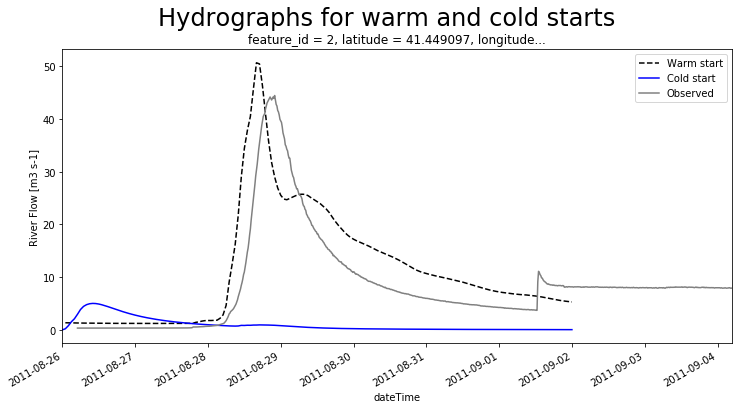

In [13]:
fig, axes = plt.subplots(ncols=1,figsize=(12, 6))
plt.suptitle('Hydrographs for warm and cold starts',fontsize=24)
chanobs_baseline.sel(feature_id = 2).streamflow.plot(label='Warm start',
                                                     color='black',
                                                     linestyle='--')
chanobs_cold.sel(feature_id = 2).streamflow.plot(label='Cold start',
                                                        color='blue',
                                                        linestyle='-')
obs[obs['site_no'] == '01374581'].plot(x='dateTime',
                                       y='streamflow_cms',
                                       ax=axes,
                                       label='Observed',
                                       color='grey')
plt.legend()
plt.show()

#### Soil moisture at start of simulation
The option `t0OutputFlag` in the *hydro.namelist* can be used to output models states at the start of the simulation.

```
! Option to write output files at time 0 (restart cold start time): 0=no, 1=yes (default)
t0OutputFlag = 1
```
We had this option set to 1 for both of our simulations so that we have outputs at the first timestep. 

**Load the LDASOUT datasets from the land surface model**

In [14]:
ldasout_baseline = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson4/run_gridded_baseline/*LDASOUT*',
                            concat_dim='time')
ldasout_cold = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson4/run_cold_start/*LDASOUT*',
                            concat_dim='time')

**Plot soil moisture at start of simulation**

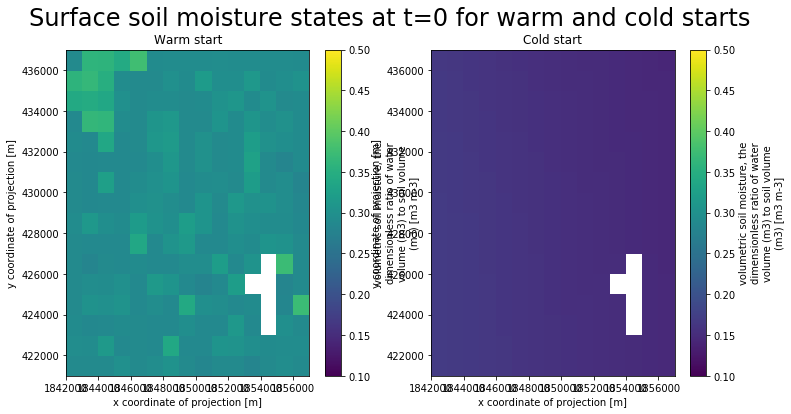

In [39]:
# Select data for t=0 at surface layer
ldasout_baseline_t0 = ldasout_baseline.sel(time = '2011-08-26T00:00:00').sel(soil_layers_stag = 0)
ldasout_cold_t0 = ldasout_cold.sel(time = '2011-08-26T00:00:00').sel(soil_layers_stag = 0)

fig, axes = plt.subplots(ncols=2,figsize=(12, 6))
plt.suptitle('Surface soil moisture states at t=0 for warm and cold starts',fontsize=24)
ldasout_baseline_t0.SOIL_M.plot(ax=axes[0],vmin=0.1,vmax=0.5)
axes[0].set_title('Warm start')
ldasout_cold_t0.SOIL_M.plot(ax=axes[1],vmin=0.1,vmax=0.5)
axes[1].set_title('Cold start')
plt.show()

### Discussion

Note that the streamflow for the cold start at the start of the simulation is 0 while the streamflow from the warm start (baseline) is > 0. Additionally, the cold start simulation begins with relatively low soil moisture (coming from the **SMOIS** variable in *wrfinput_d01.nc* file) while the warm start simulation begins with higher soil moisture content (coming from the restart file). As a result they have different responses to the rainfall event. Since the cold-start simulation soil is relatively drier, it has a higher capacity to store water and therefore more precipitation is partitioned to soil moisture (vs. runoff) compared to the warm-start simulation. This is a good example of why you almost always want to spinup your model prior to analyzing output.

## Experiment 2 - Supplemental Precipitation Data
### Background
Precipitation in commonly the most important driver of hydrologic response. In some applications, for example a flood simulation, you may want to combine atmospheric analyses from reanalysis products or other models with a separate analysis of precipitation (e.g. a gridded gauge product, radar QPE, nowcasts, satellite QPE, etc). To enable such behavior, WRF-Hydro has an option (forcing type 6) to pair standard HRLDAS atmospheric forcing files with supplemental precipitation files.

### Objective
Demonstrate the use of supplemental precipiation data for forcing our simulation.

### Create experiment simulation directory
First we will copy our template directory `~/wrf-hydro-training/output/lesson4/run_gridded_template` to create a new simulation directory for this experiment.

In [41]:
%%bash
cp -r ~/wrf-hydro-training/output/lesson4/run_gridded_template \
~/wrf-hydro-training/output/lesson4/run_supp_precip

### Edit the namelist and FORCING data and run the simulation

**Step 1: Edit the `namelist.hrldas`**

The forcing data type is specified in the `namelist.hrldas` file with the variable `FORC_TYP`. We will change the value from `FORC_TYP=1` for standard HRLDAS hourly format data (all input variables combined into a single LDASIN file per timestep) to `FORC_TYP=6`, which reads both the standard HRLDAS hourly input files AND supplemental precipitation data files.

```
&WRF_HYDRO_OFFLINE

! Specification of forcing data:  1=HRLDAS-hr format, 2=HRLDAS-min format, 3=WRF,
!    4=Idealized, 5=Ideal w/ Spec.Precip., 6=HRLDAS-hrl y fomat w/ Spec. Precip,
FORC_TYP = 6
```
**Step 2: Extract the supplemental precipitation data included with the example case**

In the supplemental folder in the example case there is a tar file `supp_precip.tar.gz` containing regridded StageIV precipitation data. We will extract this to use for augmenting our FORCING data.

In [42]:
%%bash
cd ~/wrf-hydro-training/example_case/supplemental/
tar -xf ~/wrf-hydro-training/example_case/supplemental/supp_precip.tar.gz 
ls ~/wrf-hydro-training/example_case/supplemental/supp_precip | head -10

201108260000.PRECIP_FORCING.nc
201108260100.PRECIP_FORCING.nc
201108260200.PRECIP_FORCING.nc
201108260300.PRECIP_FORCING.nc
201108260400.PRECIP_FORCING.nc
201108260500.PRECIP_FORCING.nc
201108260600.PRECIP_FORCING.nc
201108260700.PRECIP_FORCING.nc
201108260800.PRECIP_FORCING.nc
201108260900.PRECIP_FORCING.nc


**Step 3: Create a symlink to the supplemental precipitation data**

We will add in our supplemental precipitation data to the FORCING folder. Since these data can be rather large we will create a symbolic link.

In [43]:
%%bash
ln -s ~/wrf-hydro-training/example_case/supplemental/supp_precip/20110* \
~/wrf-hydro-training/output/lesson4/run_supp_precip/FORCING/

Lets take a look at the `FORCING` directory with the new data.

In [44]:
%%bash
ls ~/wrf-hydro-training/output/lesson4/run_supp_precip/FORCING/ | head -10

2011082600.LDASIN_DOMAIN1
201108260000.PRECIP_FORCING.nc
2011082601.LDASIN_DOMAIN1
201108260100.PRECIP_FORCING.nc
2011082602.LDASIN_DOMAIN1
201108260200.PRECIP_FORCING.nc
2011082603.LDASIN_DOMAIN1
201108260300.PRECIP_FORCING.nc
2011082604.LDASIN_DOMAIN1
201108260400.PRECIP_FORCING.nc


Now you see two files per hour. The *PRECIP_FORCING* files will be used for precipitation inputs and *LDASIN_DOMAIN* files will be used for all other forcing fields (e.g., temperature, radiation, wind). Note that the supplemental *PRECIP_FORCING* files are always specified to the minute.

**Step 3: Run the simulation**

In [45]:
%%bash
cd ~/wrf-hydro-training/output/lesson4/run_supp_precip
mpirun -np 2 ./wrf_hydro.exe >> run.log 2>&1

### Results
We will now look at the differences in streamflow between our baseline run with NLDAS precipitation and our experiment with supplemental StageIV precipitation.

We will use Python and the *xarray* library to load the data and plot hydrographs. For an intro to these tools, please see lesson 3.

**Load the xarray python package**

In [46]:
# Load the xarray package
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### Hydrographs
**Load the CHANOBS streamflow datasets**

Again, we use the CHANOBS files to import the streamflow timeseries at specified gage locations.

In [47]:
chanobs_baseline = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson4/run_gridded_baseline/*CHANOBS*',
                            concat_dim='time')
chanobs_supp_precip = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson4/run_supp_precip/*CHANOBS*',
                            concat_dim='time')
obs = pd.read_csv('/home/docker/wrf-hydro-training/example_case/USGS_obs.csv',dtype=str)
obs['dateTime'] = pd.to_datetime(obs['dateTime'])
obs['streamflow_cms'] = pd.to_numeric(obs['streamflow_cms'])

**Plot the hydrographs**

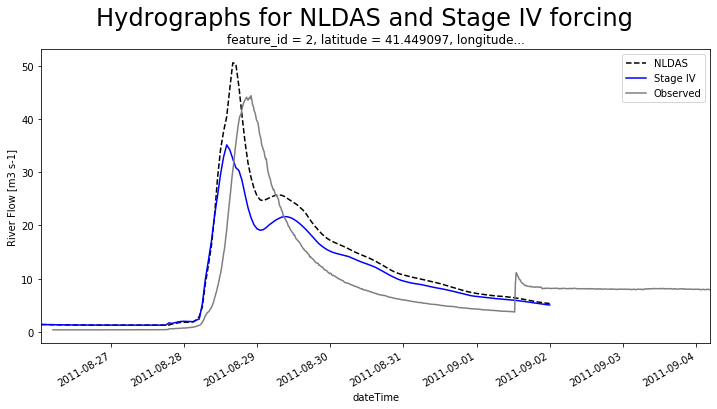

In [48]:
fig, axes = plt.subplots(ncols=1,figsize=(12, 6))
plt.suptitle('Hydrographs for NLDAS and Stage IV forcing',fontsize=24)
chanobs_baseline.sel(feature_id = 2).streamflow.plot(label='NLDAS',
                                                     color='black',
                                                     linestyle='--')
chanobs_supp_precip.sel(feature_id = 2).streamflow.plot(label='Stage IV',
                                                        color='blue',
                                                        linestyle='-')
obs[obs['site_no'] == '01374581'].plot(x='dateTime',
                                       y='streamflow_cms',
                                       ax=axes,
                                       label='Observed',
                                       color='grey')
plt.legend()
plt.show()

#### Precipitation data

We read in the precipitation time series data from the two different products using xarray.

In [49]:
ldasin = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson4/run_gridded_baseline/FORCING/*LDASIN*',
                            concat_dim='Time')
stageiv = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson4/run_supp_precip/FORCING/*PRECIP*',
                            concat_dim='Time')

Now we calculate a domain-wide mean precipitation time series and plots the two products.

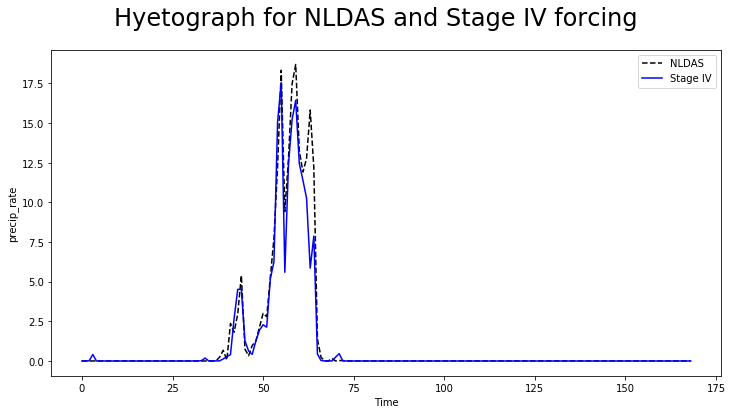

In [50]:
# Calculate the mean precipitation rate (mm/hr) across the domain
ldasin_avg = ldasin.RAINRATE.mean(dim=('south_north','west_east')) * 3600
stageiv_avg = stageiv.precip_rate.mean(dim=('south_north','west_east')) * 3600

# Plot the precipitation time series
fig, axes = plt.subplots(ncols=1,figsize=(12, 6))
plt.suptitle('Hyetograph for NLDAS and Stage IV forcing',fontsize=24)
ldasin_avg.plot(label='NLDAS', color='black', linestyle='--')
stageiv_avg.plot(label='Stage IV', color='blue', linestyle='-')
plt.legend()
plt.show()

While the domain-average precipitation time series is mostly consistent between the products, Stage IV shows somewhat lower precipitation towards the end of the event.

Since the two products have different native spatial resolutions (NLDAS is ~13km while Stage IV is ~4km), we should also examine the spatial patterns of precipitation.

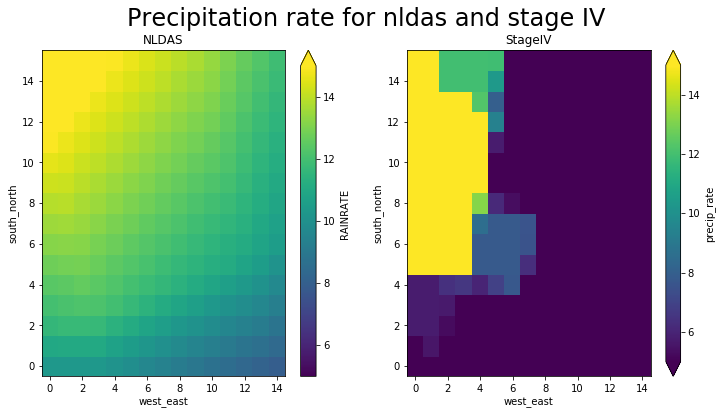

In [51]:
# Select data for roughly middle of event
ldasin_tmid = ldasin.isel(Time = 64)
stageiv_tmid = stageiv.isel(Time = 64)

# Plot the 2D precipitation grids at hour 60.
fig, axes = plt.subplots(ncols=2,figsize=(12, 6))
plt.suptitle('Precipitation rate for nldas and stage IV',fontsize=24)
ldasin_tmid['RAINRATE'] = ldasin_tmid.RAINRATE*3600
ldasin_tmid.RAINRATE.plot(ax=axes[0],vmin=5,vmax=15)
axes[0].set_title('NLDAS')
stageiv_tmid['precip_rate'] = stageiv_tmid.precip_rate*3600
stageiv_tmid.precip_rate.plot(ax=axes[1],vmin=5,vmax=15)
axes[1].set_title('StageIV')
plt.show()

### Discussion 
The spatial pattern of the two precipitation forcing datasets are very different. Stage IV peaks on the north-west part of the domain and does not contribute to streamflow generation. Additionally, the upstream contributing area has generally a higher mean precipitation rate in the NLDAS forcing compared to the StageIV, resulting in lower streamflow when using the StageIV precip.

# Next up - Exploring terrain physics
This concludes lesson 4. In the next lesson, we will explore terrain physics options and parameters.

**IT IS BEST TO EITHER SHUTDOWN THIS LESSON OR CLOSE IT BEFORE PROCEEDING TO THE NEXT LESSON TO AVOID POSSIBLY EXCEEDING ALLOCATED MEMORY. Shutdown the lesson be either closing the browser tab for the lesson or selecting `KERNAL->SHUTDOWN` in the jupyter notebook toolbar.**